In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import datetime
from sklearn.preprocessing import LabelEncoder

import sklearn
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

plt.rcParams["figure.figsize"] = (20,10)

In [598]:
data = pd.read_csv('icl_train.csv')

In [3]:
def show_data_by_dates(data,column_name,
                       left = datetime.date(2019, 1, 1),
                       right = datetime.date(2019, 2, 1)):
  group = data[[column_name,'day_date']].groupby(by = ['day_date']).sum()
  x = group.index
  y = group[column_name]
  fig, ax = plt.subplots()
  ax.plot_date(x, y,'b-')
  fig.autofmt_xdate()
  ax.set_xlim([left, right])

In [4]:
def plot_timeseries(df, station, start_date, end_date):
    fig, ax = plt.subplots(figsize=(20,8))
    st_df = df[df.zone == station][['date', 'total']]
    st_df = st_df.loc[(st_df.date >= pd.to_datetime(start_date)) & (st_df.date <= pd.to_datetime(end_date))]
    ax.plot(st_df.date, st_df.total, '.--')
    ax.set_title(station)
    plt.show();

In [599]:
#change data
data['total'] = data.iloc[:, 2:].sum(axis=1)
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].apply(lambda x: x.year)
data['day'] = data['date'].apply(lambda x: x.day)
data['hour'] = data['date'].apply(lambda x: x.hour)
data['day_date'] = data['date'].apply(lambda x: x.date())
data['day_date'] = pd.to_datetime(data['day_date'])
data['day_name'] = data['date'].apply(lambda x: x.day_name())
data['day_year'] = data['date'].apply(lambda x: x.dayofyear)                                  


In [600]:
stations = data['zone'].unique()

In [ ]:
#plot_timeseries(data, stations[0], '20190105', '20190107')

In [166]:
def add_lag(df,column_name,lag_length):
  for lag in range(1,lag_length+1):
    df[column_name+'_'+str(lag)] = df[column_name].shift(lag)
  return df

#amount - количество дней/часов в году..
def encode_time(df, column_name, amount):
  df[column_name+'_s'] = df[column_name].apply(lambda x: np.sin((2*np.pi)/amount*x))
  df[column_name+'_c'] = df[column_name].apply(lambda x: np.cos((2*np.pi)/amount*x))
  return df

def moving_average(df, column_name, moving_length):
  df[column_name+'_ma_'+str(moving_length)] = df[column_name].rolling(window=moving_length).mean().shift(1)
  return df

def gaussian_average(df, column_name, moving_length):
  df[column_name+'_ga_'+str(moving_length)] = df[column_name].rolling(window=moving_length, win_type='gaussian').mean(std=0.5).shift(1)
  return df

def exp_average(df, column_name):
  df[column_name+'_ea_'] = df[column_name].ewm(com=0.5).mean().shift(1)
  return df

def day_off(day):
  if day in ['Sunday','Saturday']:
    return 1
  else:
    return 0

def salary_day(day):
  if ((day>24) or (day<6)):
    return 1
  else:
    return 0

# Add_data

In [601]:
data_weather = pd.read_csv('weather_prepared_interpolated.csv', encoding='1251', sep = ',')
data_weather = pd.concat([data_weather,pd.get_dummies(data_weather['weather'])],axis=1)
data_weather = data_weather.drop(columns = ['weather'])
data_weather['date'] = pd.to_datetime(data_weather['Unnamed: 0'])
weather_columns = ['temp', 'w_spid', 'p', 'малооблачно', 'облачно',
       'пасмурно', 'ясно']
#data_weather = data_weather.set_index('Unnamed: 0')

#data = data.set_index('date')
#data = data.join(data_weather, lsuffix='', rsuffix='',how = 'left')
data = pd.merge(data, data_weather,  how='left', left_on=['date'], right_on = ['date'])

In [602]:
data_covid = pd.read_csv('covid_tatarstan.csv', encoding='1251', sep = ';')
data_covid['DateTime'] = pd.to_datetime(data_covid['DateTime'])
covid_columns = ['Заражений за день']
data_covid['day_date'] = data_covid['DateTime']
data_covid = data_covid.drop(columns = ['DateTime'])

data = pd.merge(data, data_covid,  how='left', left_on=['day_date'], right_on = ['day_date'])

In [603]:
data = data.fillna(0)

# Preprocessing

In [117]:
#time_columns = ['date','year','day_year','day','hour','zone','day_name','Перевозка плановая']
#train_df = data[time_columns+weather_columns+covid_columns].query('zone == @stations[0]')

In [118]:
#train_df.isnull().sum()

date                  0
year                  0
day_year              0
day                   0
hour                  0
zone                  0
day_name              0
Перевозка плановая    0
temp                  0
w_spid                0
p                     0
малооблачно           0
облачно               0
пасмурно              0
ясно                  0
Заражений за день     0
dtype: int64

In [500]:
#day_name_unique = data['day_name'].unique()
def preprocessing(train_df, column_name, lag_length = 100):
  moving_length = [6]
  moving_column_names = []

  train_df = encode_time(train_df,'hour',24)
  train_df = encode_time(train_df,'day',30)
  train_df = encode_time(train_df,'day_year',365)

  #train_df = pd.concat([train_df,pd.get_dummies(train_df['year'])],axis=1)
  #не смог найти get_dummies с обучением
  #train_df = pd.concat([train_df,pd.get_dummies(train_df['day_name'], columns = day_name_unique)],axis=1)
  train_df['day_off'] = train_df['day_name'].apply(day_off)
  train_df['salary_day'] = train_df['day'].apply(salary_day)

  #Все фичи для которых можно сделать average + lag
  for clmn in [column_name,'Заражений за день','temp','w_spid']:
    for i in moving_length:
      train_df = moving_average(train_df, clmn, i)
      moving_column_names.append(clmn+'_ma_'+str(i))
    #for i in moving_length:
    #  train_df = gaussian_average(train_df, clmn, i)
    #  moving_column_names.append(clmn+'_ga_'+str(i))
    #train_df = exp_average(train_df, clmn)
    #moving_column_names.append(clmn+'_ea_')
    moving_column_names.append(clmn)

  #Дифференциал
  for diff_feature in moving_column_names:
    train_df[diff_feature+'_diff'] = train_df[diff_feature].diff().shift(1)

  #Лаги
  for lag_feature in moving_column_names:
    train_df = add_lag(train_df,lag_feature,lag_length)

  additional_lag_columns = ['salary_day','day_off']
  for lag_feature in additional_lag_columns:
    train_df = add_lag(train_df,lag_feature,3)

  train_df = train_df.dropna()
  #train_df = train_df.drop(columns = ['date','year','day_year','day','hour','zone','day_name'])

  return train_df

# LinReg (не юзать)

In [ ]:
columns_to_test = ['Перевозка плановая','Вызов специальной бригады','Перевозка экстренная']
stations_to_test = stations[0:3]
time_columns = ['date','year','day_year','day','hour','zone','day_name']
lag_length = 10

final_mae = np.array([])

for column_name in tqdm(columns_to_test):
  for station in stations_to_test:
    train_df = data[time_columns+weather_columns+covid_columns+[column_name]].query('zone == @station')
    train_df = preprocessing(train_df,column_name, lag_length)

    train_df = train_df.reset_index()
    train_df = train_df.drop(columns = ['index'])
    X = train_df.drop(columns = ['date','year','day_year','day','hour','zone','day_name', column_name])
    Y = train_df[column_name]
    
    lr_rmse_list = np.array([])
    tscv = TimeSeriesSplit()
    for train_index, test_index in tscv.split(X):
      X_train, X_test = X.loc[train_index], X.loc[test_index]
      y_train, y_test = Y.loc[train_index], Y.loc[test_index]
      
      # ТУТ УЧИМ И ТЕСТИМ
      #lr_model = LinearRegression()
      lr_model = Ridge(alpha=0.7)
      lr_model.fit(X_train,y_train)
      
      predicted = lr_model.predict(X_test).round()
      lr_rmse = mean_absolute_error(y_test,predicted)
      lr_rmse_list = np.append(lr_rmse_list,lr_rmse)
      
      #print('MAE = %.2f' % lr_rmse)
    final_mae = np.append(final_mae,lr_rmse.mean())
    print('\n',pd.Series(predicted).value_counts())
    print(lr_rmse_list)
    print('MAE ', column_name,' ', station,' - ', lr_rmse_list.mean())
    print('All 0', mean_absolute_error(y_test,np.zeros(len(y_test))),'\n')

print('*'*10+'\n')
print('MAE: ', final_mae.mean(),' lag: ', lag_length)

# Predict 1 step forward

In [190]:
from datetime import timedelta

In [605]:
# Обрезаем weather and covid
data_weather = data_weather[data_weather['date']>pd.to_datetime('20201231')]
data_covid = data_covid[data_covid['day_date']>pd.to_datetime('20201231')]

In [520]:
#data - конец временного ряда (датасета)

def predict_1_step(cut_df, column_name, station, lag_length, model):
  
  columns_to_save = cut_df.columns
  date = cut_df['date'].iloc[-1] + timedelta(minutes=60)
  year = date.year
  day_year = date.dayofyear
  day = date.day
  hour = date.hour
  zone = station
  day_name = date.day_name()
  cut_weather = data_weather[data_weather['date'] == date][weather_columns].to_numpy()
  cut_covid = data_covid[data_covid['day_date'] == pd.Timestamp.round(date,freq='d')][covid_columns].to_numpy()#.reshape(1,)
  target = -1 #потом перезаписывается

  new_row = np.array([date,year,day_year,day,hour,zone,day_name])
  new_row = np.hstack((new_row,cut_weather.ravel(),cut_covid.ravel(),target))
  cut_df.loc[len(cut_df)] = new_row

  temp = preprocessing(cut_df, column_name, lag_length)

  x = np.array(temp.drop(columns = ['date','year','day_year','day','hour','zone','day_name', column_name]).iloc[-1])
  y_pred = model.predict(x.reshape(1,-1)).round()

  #cut_df.at[index,'column-name']='new value'
  cut_df.loc[cut_df.index[-1],[column_name]] = y_pred
  #cut_df = cut_df.replace(-1, y)

  return cut_df[columns_to_save]

# Final_predictions

In [547]:
with open('../to_remove.txt') as f:
    lines = f.read().splitlines()

need_to_predict = list(set(cols) - set(lines))
need_to_predict_1 = need_to_predict[:int(len(need_to_predict)/2)]
need_to_predict_2 = need_to_predict[int(len(need_to_predict)/2):]

In [ ]:
stations = data['zone'].unique()

In [ ]:
cut = 100
for column_name in need_to_predict_1:
  for station in stations:
    time_columns = ['date','year','day_year','day','hour','zone','day_name']
    lag_length = 10

    train_df = data[time_columns+weather_columns+covid_columns+[column_name]].query('zone == @station')
    train_df = preprocessing(train_df,column_name, lag_length)

    train_df = train_df.reset_index()
    train_df = train_df.drop(columns = ['index'])
    X = train_df.drop(columns = ['date','year','day_year','day','hour','zone','day_name', column_name])
    Y = train_df[column_name]
    
    # ТУТ УЧИМ
    lr_model = Ridge(alpha=0.7)
    lr_model.fit(X,Y)
    
    cut_df = data[time_columns+weather_columns+covid_columns+[column_name]].query('zone == @station').iloc[-cut:]

    for i in tqdm(range(90*24)):
      cut_df = predict_1_step(cut_df, column_name, station, lag_length, lr_model)

    cut_df.to_csv(column_name+'_'+station.replace('/','')+'.csv')
    print(column_name+'   '+station + 'Done')

In [606]:
cut = 100
for column_name in ['total']:
  for station in stations:
    time_columns = ['date','year','day_year','day','hour','zone','day_name']
    lag_length = 10

    train_df = data[time_columns+weather_columns+covid_columns+[column_name]].query('zone == @station')
    train_df = preprocessing(train_df,column_name, lag_length)

    train_df = train_df.reset_index()
    train_df = train_df.drop(columns = ['index'])
    X = train_df.drop(columns = ['date','year','day_year','day','hour','zone','day_name', column_name])
    Y = train_df[column_name]
    
    # ТУТ УЧИМ
    lr_model = Ridge(alpha=0.7)
    lr_model.fit(X,Y)
    
    cut_df = data[time_columns+weather_columns+covid_columns+[column_name]].query('zone == @station').iloc[-cut:]

    for i in tqdm(range(90*24)):
      cut_df = predict_1_step(cut_df, column_name, station, lag_length, lr_model)

    cut_df.to_csv(column_name+'_'+station.replace('/','')+'.csv')
    print(column_name+'   '+station + 'Done')

100%|██████████████████████████████████████████████████████████████████████████████| 2160/2160 [02:08<00:00, 16.81it/s]


total   П/станция 1Done


100%|██████████████████████████████████████████████████████████████████████████████| 2160/2160 [02:08<00:00, 16.87it/s]


total   П/станция 2Done


100%|██████████████████████████████████████████████████████████████████████████████| 2160/2160 [02:11<00:00, 16.42it/s]


total   П/станция 3Done


100%|██████████████████████████████████████████████████████████████████████████████| 2160/2160 [02:15<00:00, 15.98it/s]


total   П/станция 4Done


100%|██████████████████████████████████████████████████████████████████████████████| 2160/2160 [02:07<00:00, 17.01it/s]


total   П/станция 5Done


100%|██████████████████████████████████████████████████████████████████████████████| 2160/2160 [02:07<00:00, 16.89it/s]


total   П/станция 6Done


100%|██████████████████████████████████████████████████████████████████████████████| 2160/2160 [02:07<00:00, 16.98it/s]


total   П/станция 7Done


100%|██████████████████████████████████████████████████████████████████████████████| 2160/2160 [02:07<00:00, 16.92it/s]


total   П/станция 8Done


100%|██████████████████████████████████████████████████████████████████████████████| 2160/2160 [02:07<00:00, 16.90it/s]

total   П/станция 9Done


In [ ]:
#cut_df[['date','total']]#.resample('total', on='time').sum()
column_name = 'total'
cut_df[['date',column_name]].groupby(cut_df[['date',column_name]].date.dt.date).sum()

In [650]:
with open('../to_remove_2.txt') as f:
    lines = f.read().splitlines()

need_to_predict_v2 = list(set(cols) - set(lines))
need_to_predict_v2 = list(set(need_to_predict_v2) - set(need_to_predict))
#need_to_predict_v2_1 = need_to_predict[:int(len(need_to_predict)/2)]
#need_to_predict_v2_2 = need_to_predict[int(len(need_to_predict)/2):]
need_to_predict_v2[12:]

['избили',
 'задыхается( бронхит, пневмония)',
 'выс. давление( немеет язык)',
 'головокружение( травмы нет)',
 'травма  головы( кровотечение)',
 'плохо с сердцем( перенес инфаркт)',
 'болит голова( травмы нет)',
 'травма головы']

In [596]:
from glob import glob
files = {}
for file_str in glob('*Пстанци*'):
  file_str_temp = file_str.split('_')[0]
  if file_str_temp not in files.keys():
    files[file_str_temp] = 1
  else:
    files[file_str_temp] += 1

set(need_to_predict) - set(list(files.keys()))

{'без сознания', 'боли в животе'}

In [ ]:
#Люба
set(['низкое давление',
'боли в животе( выс. температура)',
'рвота( выс.температура)',
'плохо с сердцем',
'парализовало',
'выс. давление( боли в сердце)',
'выс. темп.( задыхается)',
'задыхается( боли в сердце)',
'боли в животе',
'плохо',
'выс. темп'])

In [ ]:
files = []
for file_str in glob('*Пстанци*'):
  file_str_temp = file_str.split('_')[0]
  if file_str_temp not in files:
    files[file_str_temp] = 1
  else:
    files[file_str_temp] += 1

In [625]:
df = pd.read_csv('submission.csv', encoding='1251')

In [638]:
#station[-1]
glob(column_name+'_*'+station[-1]+'*')[0]

'total_Пстанция 9.csv'

#Trash

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  2.,  2.,  0.,  0.,  2.,
         1.,  0.,  2.,  2.,  2.,  1.,  2.,  2.,  2.,  4.,  6.,  5.,  4.,
         1.,  2.,  4.,  6.,  5., 11., 11., 20., 43.]),
 array([0.7128891 , 0.71575565, 0.7186222 , 0.72148874, 0.72435529,
        0.72722184, 0.73008839, 0.73295493, 0.73582148, 0.73868803,
        0.74155457, 0.74442112, 0.74728767, 0.75015422, 0.75302076,
        0.75588731, 0.75875386, 0.7616204 , 0.76448695, 0.7673535 ,
        0.77022005, 0.77308659, 0.77595314, 0.77881969, 0.78168623,
        0.78455278, 0.78741933, 0.79028588, 0.79315242, 0.79601897,
        0.79888552, 0.8017

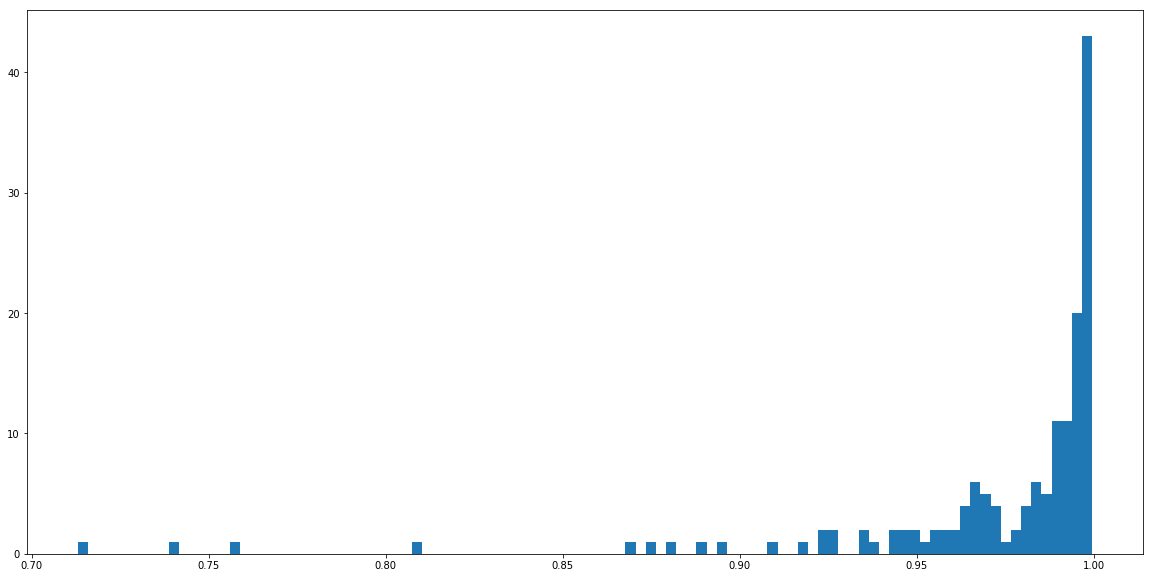

In [529]:
cols = [
         'Перевозка плановая',
         'боли в животе',
         'выс. темп.',
         'плохо с сердцем',
         'Перевозка экстренная',
         'выс. давление( боли в сердце)',
         'задыхается',
         'плохо',
         'без сознания',
         'выс. давление( голов.боль,головокруж)',
         'выс. давление',
         'плохо с сердцем( выс. давление)',
         'теряет сознание',
         'парализовало',
         'плохо с сердцем( боль за грудиной)',
         'задыхается( боли в сердце)',
         'боли в животе( жидкий стул)',
         'выс. темп.( задыхается)',
         'рвота( болит живот)',
         'рвота',
         'боли в животе( выс. температура)',
         'травма ноги',
         'рвота( выс.температура)',
         'задыхается( бронхит, пневмония)',
         'боли в животе( рвота)',
         'низкое давление',
         'плохо с сердцем( аритмия)',
         'травма головы',
         'рвота( выс. давление)',
         'избили',
         'психоз( не лечился)',
         'плохо с сердцем( хрон)',
         'плохо с сердцем( перенес инфаркт)',
         'психоз( лечился)',
         'приступ эпилепсии',
         'болит нога( травмы нет)',
         'травма  головы( кровотечение)',
         'парализовало( отнялась рука,нога)',
         'выс. давление( отнялась рука,нога)',
         'травма руки',
         'болит спина( травмы нет)',
         'головокружение( травмы нет)',
         'приступ почек',
         'выс. давление( немеет язык)',
         'авария ( сбило машиной) постр.',
         'аритмия',
         'отравление( алкогольное)',
         'выс. давление( не помогают лекарства)',
         'болит голова( травмы нет)',
         'плачет',
         'аллергия( сыпь)',
         'кровотечение( желуд-кишечное)',
         'бронхиальная астма( задых.)',
         'задыхается( бронхиальная астма)',
         'плохо с сердцем( низкое давление)',
         'аллергия( отекло лицо)',
         'кровотечение( носовое)',
         'кровотечение( маточное)',
         'выс. давление( рвота)',
         'приступ( сердцебиение)',
         'боли в животе( приступ почек)',
         'плохо( выпил)',
         'судороги',
         'пожар',
         'травма позвоночника',
         'травма лица',
         'умер?',
         'психоз( алкогольный)',
         'аллергия( задыхается)',
         'дежурство платное',
         'боли в груди',
         'задыхается( аллергия)',
         'Вызов специальной бригады',
         'боли в животе( беременность)',
         'травма руки( кровотечение)',
         'кровотечение носовое',
         'судороги( приступ эпилепсии)',
         'выс. темп.( сыпь)',
         'бронхиальная астма( хрон)',
         'боли в груди( продуло)',
         'задержка мочи',
         'не дышит',
         'кровотечение( травма)',
         'жидкий стул',
         'болит рука( травмы нет)',
         'отекло лицо( аллергия)',
         'отравление( медикаментами)',
         'отморожение',
         'выс. давление( выс. температура)',
         'выс. давление( хрон)',
         'переохлаждение',
         'умирает',
         'травма ребер( задыхается)',
         'сахарный диабет( плохо)',
         'плохо с сердцем( элект.кардиостимулятор)',
         'ножевое ранение',
         'психоз( белая горячка)',
         'травма ноги( кровотечение)',
         'судороги( выс. температура)',
         'болит ухо',
         'падение с высоты',
         'дежурство',
         'суицидальная попытка',
         'отравление пищевое',
         'весь в крови',
         'кровотечение( изо рта)',
         'травма ребер( не задыхается)',
         'взрывное устройство',
         'выс. давление( перекосило лицо)',
         'рвота( отравление)',
         'ожог глаз',
         'рвота( сахарный диабет)',
         'укусила собака',
         'инородное тело ЖКТ( пищевода)',
         'боли в животе( приступ печени)',
         'ожог термический( кипятком) ноги',
         'отек половых органов',
         'тяж.ст.опьянения',
         'отравление химическими средствами',
         'белая горячка',
         'болит глаз( травмы нет)',
         'парализовало( без сознания)',
         'рана резаная',
         'рвота( беременность)',
         'выпадение трубки',
         'инородное тело( дыхательных путей)',
         'пена изо рта( судороги)',
         'плохо( наркоман)',
         'инородное тело( носа)',
         'сахарный диабет( рвота)',
         'плохо( запой)',
         'кровотечение( вскрыл вены)',
         'кровотеч.( маточное ) беременность',
         'отравление угарным газом',
         'без сознания( травма головы)',
         'посинел',
         'рана инфицированная',
         'травма пальца( кровотечение)',
         'приступ печени',
         'психоз( есть направление)',
         'травма живота',
         'без сознания( сахарный диабет)',
         'умер?( хронический больной)',
         'ожог термический( кипятком) руки',
         'роды 2',
         'пена изо рта( без сознания)',
         'ожог химический',
         'сахарный диабет( без сознания)',
         'боли в груди( травма грудной клетки)',
         'истерия',
         'наркоман( передозировка)',
         'ожог термический( кипятком ) всего тела',
         'огнестрельное ранение'
]

arr = []
for c in cols:
  arr.append(data[c].value_counts()[0]/len(data))

plt.hist(arr,bins = 100)